# 1. Data Exploration and feature extraction

From the documentation we see that:
"The input images are expected to have color values in the range [0,1], following the common image input conventions. For this model, the size of the input images is fixed to height x width = 224 x 224 pixels."

## Loading Image Dataset

In [1]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Define image size and scaling
image_size = (224, 224)
batch_size = 32

datagen = ImageDataGenerator(rescale=1./255)  # Adjust rescaling if needed
print('Training set:')
trainset = datagen.flow_from_directory('./train', target_size=image_size, batch_size=batch_size)
print('Validation set:')
validset = datagen.flow_from_directory('./valid', target_size=image_size, batch_size=batch_size)
print('Testing set:')
testset = datagen.flow_from_directory('./test', target_size=image_size, batch_size=batch_size)


2024-11-11 18:47:48.055791: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2024-11-11 18:47:48.055831: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


Training set:
Found 280 images belonging to 6 classes.
Validation set:
Found 139 images belonging to 6 classes.
Testing set:
Found 50 images belonging to 6 classes.


In [2]:
class_labels = list(validset.class_indices.keys())
class_labels

['bike', 'car', 'motorcycle', 'other', 'truck', 'van']

## Plotting of few images

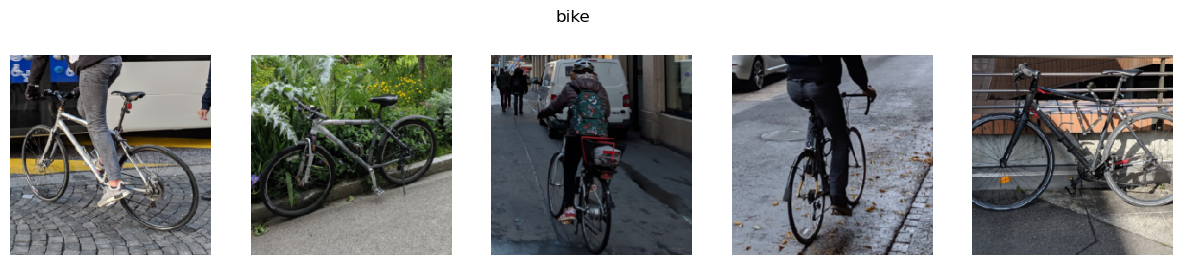

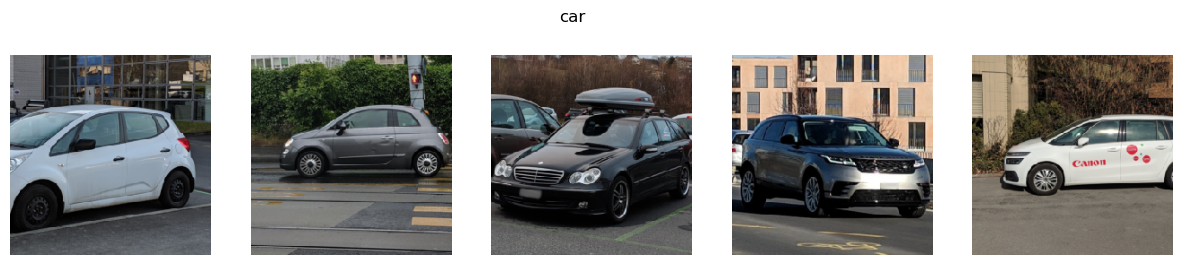

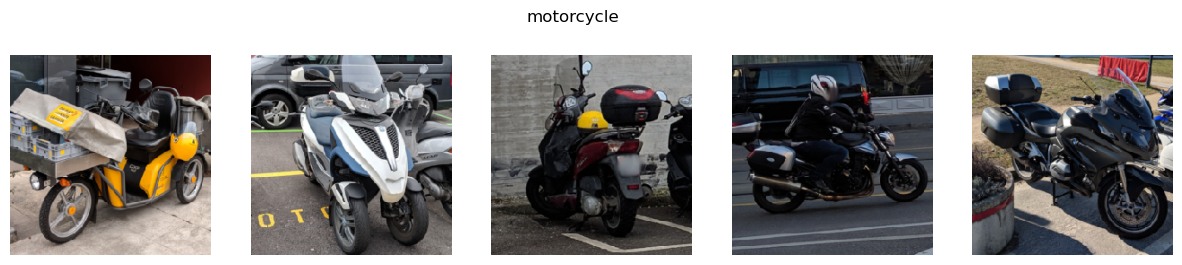

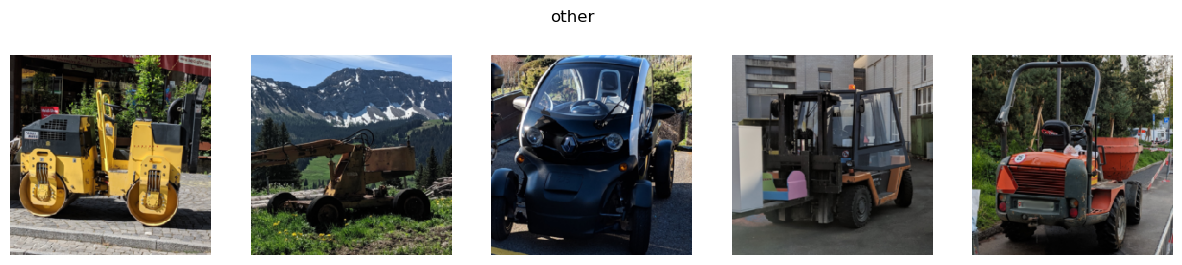

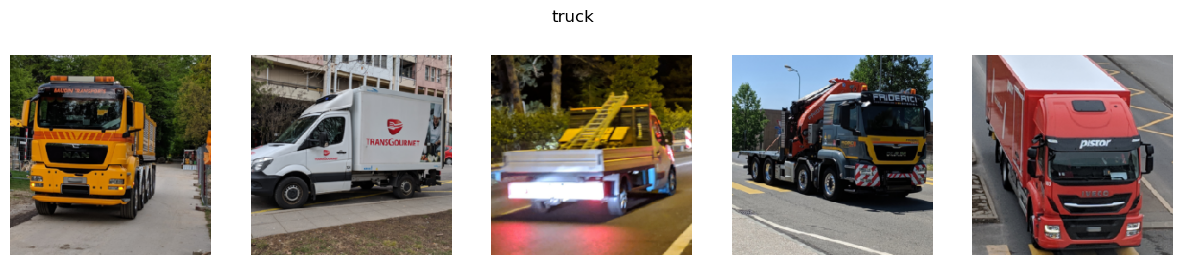

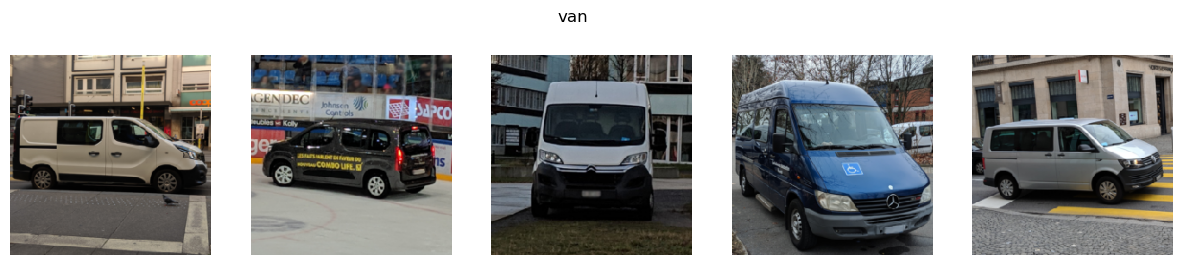

In [3]:
import matplotlib.pyplot as plt

def plot_samples(data, category):
    
    fig, axes = plt.subplots(1, 5, figsize=(15, 3))
    fig.suptitle(category)
    
    k=0
    while k<5:

        images, labels = next(iter(data))
    
        for n,label in enumerate(labels):
            if label[class_labels.index(category)] == 1:
                axes[k].imshow(images[n]) 
                axes[k].axis('off')
                k+=1
                if k==5:
                    break

for category in class_labels:
    plot_samples(trainset, category)


## Category distributions

(0.0, 0.25)

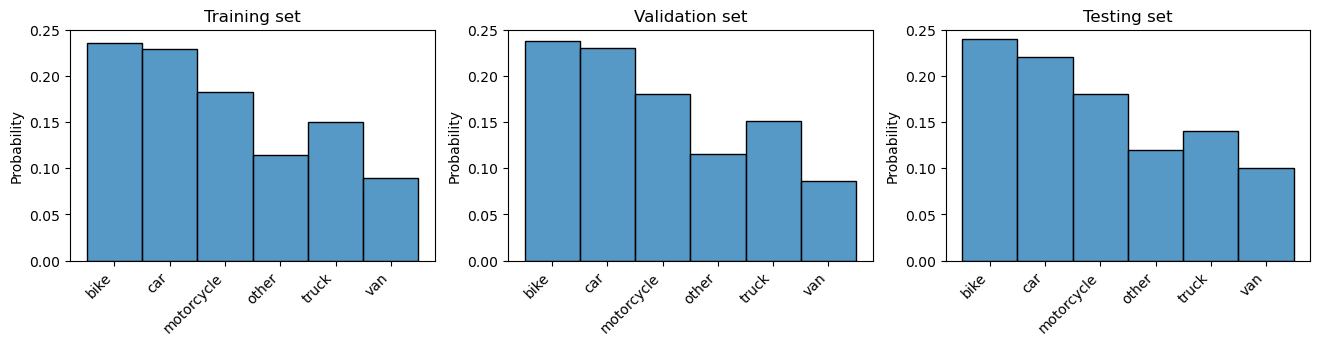

In [4]:
import seaborn as sns
import numpy as np

class_dist = {'test': testset.classes, 'valid': validset.classes,'train': trainset.classes}


fig, axes = plt.subplots(1, 3, figsize=(16, 3))

sns.histplot(trainset.classes, binwidth=1, binrange=(0,6), stat='probability', ax=axes[0])
axes[0].set_title('Training set')
axes[0].set_xticks(np.arange(len(class_labels))+0.5)
axes[0].set_xticklabels(class_labels, rotation=45, ha='right')
axes[0].set_ylim(0,0.25)

sns.histplot(validset.classes, binwidth=1, binrange=(0,6), stat='probability', ax=axes[1])
axes[1].set_title('Validation set')
axes[1].set_xticks(np.arange(len(class_labels))+0.5)
axes[1].set_xticklabels(class_labels, rotation=45, ha='right')
axes[1].set_ylim(0,0.25)

sns.histplot(testset.classes, binwidth=1, binrange=(0,6), stat='probability', ax=axes[2])
axes[2].set_title('Testing set')
axes[2].set_xticks(np.arange(len(class_labels))+0.5)
axes[2].set_xticklabels(class_labels, rotation=45, ha='right')
axes[2].set_ylim(0,0.25)

All three set have almost identical class distribution.

## Training Set total color histogram

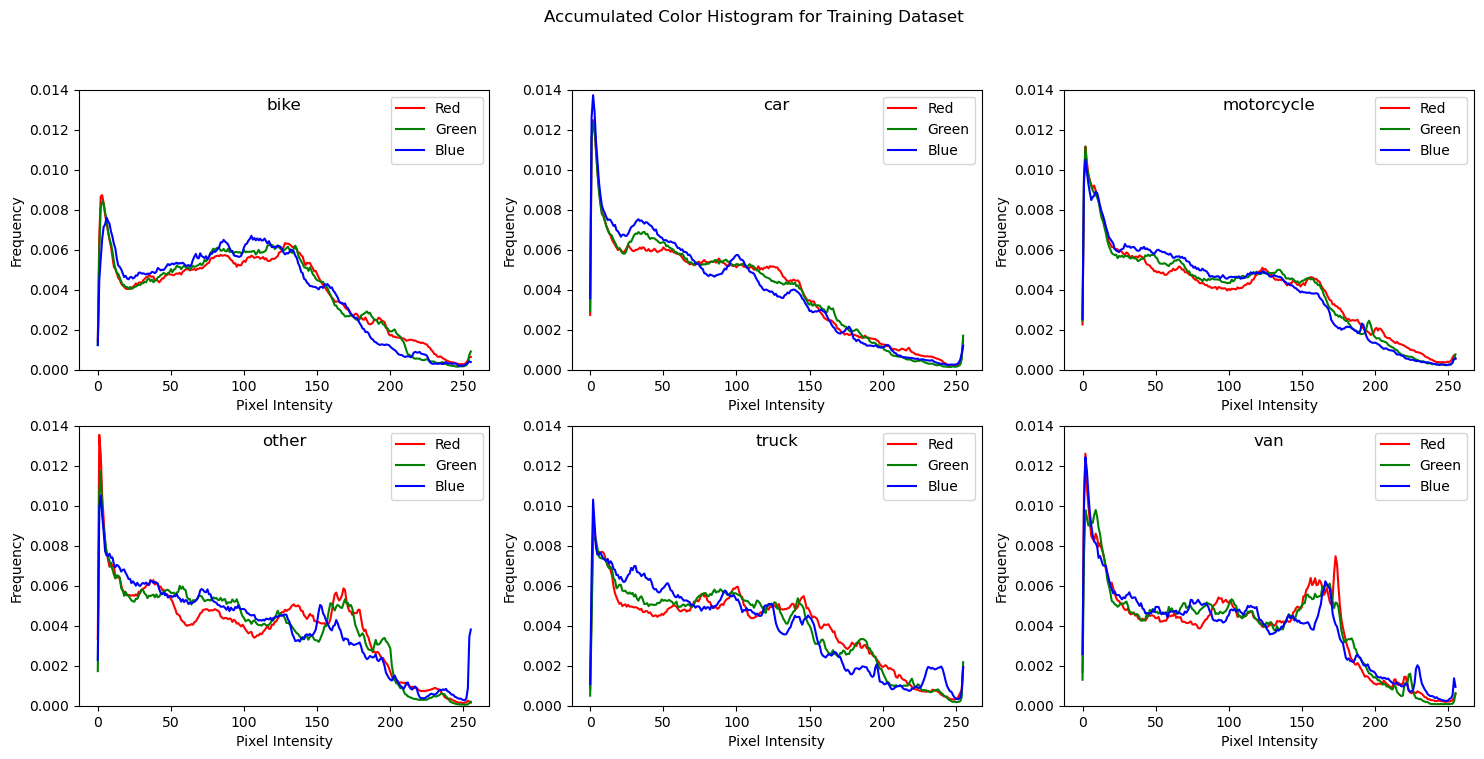

In [5]:
def plot_histograms(data, category):

    hist_r_total = np.zeros(256)
    hist_g_total = np.zeros(256)
    hist_b_total = np.zeros(256)

    while True:
        images, labels = next(iter(data))
        for n,label in enumerate(labels):
            if label[class_labels.index(category)] == 1:

                # Calculate histograms for each channel (R, G, B) separately
                hist_r, _ = np.histogram(images[n, :, :, 0].ravel()*256, bins=256, range=(0, 256))
                hist_g, _ = np.histogram(images[n, :, :, 1].ravel()*256, bins=256, range=(0, 256))
                hist_b, _ = np.histogram(images[n, :, :, 2].ravel()*256, bins=256, range=(0, 256))
                
                # Accumulate histograms
                hist_r_total += hist_r
                hist_g_total += hist_g
                hist_b_total += hist_b

        if len(labels) < 32:
            break

    # Normalize histograms if desired (optional)
    hist_r_total /= hist_r_total.sum()
    hist_g_total /= hist_g_total.sum()
    hist_b_total /= hist_b_total.sum()

    return hist_r_total, hist_g_total, hist_b_total

# Plot the accumulated color histograms
fig, axes = plt.subplots(2, 3, figsize=(18, 8))
axes = axes.ravel()
fig.suptitle('Accumulated Color Histogram for Training Dataset')

for k, category in enumerate(class_labels):
    
    hist_r_total, hist_g_total, hist_b_total = plot_histograms(trainset, category)

    axes[k].plot(hist_r_total, color='red', label='Red')
    axes[k].plot(hist_g_total, color='green', label='Green')
    axes[k].plot(hist_b_total, color='blue', label='Blue')

    axes[k].set_title(category, y=0.9)
    axes[k].set_xlabel('Pixel Intensity')
    axes[k].set_ylabel('Frequency')
    axes[k].set_ylim(0,0.014)
    axes[k].legend()

There are some structures/shapes that could hint at differentiate betweeen some groups of categories, but it would be almost impossible to differentiate the 6 categories with just the color informatiom. Additionally, here we observe the total mean of all images from a given category, but we don't have a view on the signal variance within each category. 

## Extraction of High-Level features

In [6]:
import tensorflow_hub as hub

# Create the image feature extractor
model_url = "https://tfhub.dev/google/imagenet/mobilenet_v2_100_224/feature_vector/5"

# Two options:
# 1
feature_extractor = hub.load(model_url)
# 2
# feature_extractor = hub.KerasLayer(model_url, input_shape=(224, 224, 3), trainable=False)

2024-11-11 18:48:09.670548: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:923] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-11-11 18:48:09.670671: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2024-11-11 18:48:09.670743: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcublas.so.11'; dlerror: libcublas.so.11: cannot open shared object file: No such file or directory
2024-11-11 18:48:09.670789: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcublasLt.so.11'; dlerror: libcublasLt.so.11: cannot open shared object file: No such file or directory
2024-11-11 18:48:09.670831: W tensorflow/stream_executor/platform/default/dso_loader.cc:6

In [7]:
testset_features = feature_extractor(testset)
testset_features.shape

: 